In [2]:
# import the serious stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

/home/aswin/project/book_id/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# create random images
no_of_images = 50000
image_size = 8
min_object_size = 1
max_object_size = 4
no_of_objects = 1 # number of squares in an image

# stores list of boundary of every object
bounding_boxes = np.zeros((no_of_images, no_of_objects, 4))
# list of images
images = np.zeros((no_of_images, image_size, image_size))

for i_image in range(no_of_images):
    for i_object in range(no_of_objects):
        # size is the no of random variables to be generated
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, image_size - w)
        y = np.random.randint(0, image_size - h)
        images[i_image, x:x+w, y:y+h] = 1.
        bounding_boxes[i_image, i_object] = [x, y, w, h]

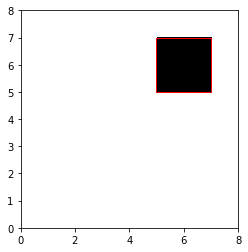

In [4]:
# debug
# .T does diagonal transform
plt.imshow(images[0].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
for bounding_box in bounding_boxes[0]:
    # apparently draws bounding boxes
    plt.gca().add_patch(matplotlib.patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2], bounding_box[3], ec='r', fc='none'))

In [6]:
# normalize data to mean 0 and std 1, -1 means dimension is unknown
normalized_data = (images.reshape(no_of_images, -1) - np.mean(images) / np.std(images))

In [17]:
# normalize x, y, w, h by image_size, so all values are between 0 and 1
print(np.std(images))
print(np.mean(images))

0.24266369703962207
0.06283375
